In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from time import time
from scipy.sparse import csc_matrix
from scipy.optimize import minimize
import tensorflow as tf
import numpy as np
import h5py

In [ ]:
print(tf.__version__)

2.12.0


**MovieLens Dataset**

This dataset contains a set of movie ratings from the MovieLens website, a movie recommendation service. This dataset was collected and maintained by GroupLens, a research group at the University of Minnesota.

**Douban**

This dataset includes three domains, i.e., movie, music, and book, and different kinds of raw information, i.e., ratings, reviews, item details, user profiles, tags (labels), and date


# Data Loader Function

In [ ]:
'''
MovieLens-100K
100,000 ratings (1-5) from 943 users on 1682 movies.
'''

def load_data_100k(path='./', delimiter='\t'):

    train = np.loadtxt(path+'movielens_100k_u1.base', skiprows=0, delimiter=delimiter).astype('int32')
    test = np.loadtxt(path+'movielens_100k_u1.test', skiprows=0, delimiter=delimiter).astype('int32')
    total = np.concatenate((train, test), axis=0)
    n_u = np.unique(total[:,0]).size  # num of users
    n_m = np.unique(total[:,1]).size  # num of movies
    n_train = train.shape[0]  # num of training ratings
    n_test = test.shape[0]  # num of test ratings
    train_r = np.zeros((n_m, n_u), dtype='float32')
    test_r = np.zeros((n_m, n_u), dtype='float32')

    for i in range(n_train):
        if train[i,1] < len(train_r) and train[i,0]-1 < len(train_r[0]):
            train_r[train[i,1]-1, train[i,0]-1] = train[i,2]

    for i in range(n_test):
        if test[i,1] < len(test_r) and test[i,0]-1 < len(test_r[0]):
            test_r[test[i,1]-1, test[i,0]-1] = test[i,2]

    train_m = np.greater(train_r, 1e-12).astype('float32')  # masks indicating non-zero entries
    test_m = np.greater(test_r, 1e-12).astype('float32')

    print('data matrix loaded')
    print('num of users: {}'.format(n_u))
    print('num of movies: {}'.format(n_m))
    print('num of training ratings: {}'.format(n_train))
    print('num of test ratings: {}'.format(n_test))

    return n_m, n_u, train_r, train_m, test_r, test_m

In [ ]:
'''
MovieLens-1M
1,000,209 anonymous ratings of approximately 3,900 movies
made by 6,040 MovieLens users
'''
def load_data_1m(path='./', delimiter='::', frac=0.1, seed=1234):

    tic = time()
    print('reading data...')
    data = np.loadtxt(path+'movielens_1m_dataset.dat', skiprows=0, delimiter=delimiter).astype('int32')
    print('taken', time() - tic, 'seconds')

    n_u = np.unique(data[:,0]).size  # num of users
    n_m = np.unique(data[:,1]).size  # num of movies
    n_r = data.shape[0]  # num of ratings

    udict = {}
    for i, u in enumerate(np.unique(data[:,0]).tolist()):
        udict[u] = i
    mdict = {}
    for i, m in enumerate(np.unique(data[:,1]).tolist()):
        mdict[m] = i

    np.random.seed(seed)
    idx = np.arange(n_r)
    np.random.shuffle(idx)

    train_r = np.zeros((n_m, n_u), dtype='float32')
    test_r = np.zeros((n_m, n_u), dtype='float32')

    for i in range(n_r):
        u_id = data[idx[i], 0]
        m_id = data[idx[i], 1]
        r = data[idx[i], 2]

        if i < int(frac * n_r):
            test_r[mdict[m_id], udict[u_id]] = r
        else:
            train_r[mdict[m_id], udict[u_id]] = r

    train_m = np.greater(train_r, 1e-12).astype('float32')  # masks indicating non-zero entries
    test_m = np.greater(test_r, 1e-12).astype('float32')

    print('data matrix loaded')
    print('num of users: {}'.format(n_u))
    print('num of movies: {}'.format(n_m))
    print('num of training ratings: {}'.format(n_r - int(frac * n_r)))
    print('num of test ratings: {}'.format(int(frac * n_r)))

    return n_m, n_u, train_r, train_m, test_r, test_m

In [ ]:
def load_matlab_file(path_file, name_field):

    db = h5py.File(path_file, 'r')
    ds = db[name_field]

    try:
        if 'ir' in ds.keys():
            data = np.asarray(ds['data'])
            ir   = np.asarray(ds['ir'])
            jc   = np.asarray(ds['jc'])
            out  = csc_matrix((data, ir, jc)).astype(np.float32)
    except AttributeError:
        out = np.asarray(ds).astype(np.float32).T

    db.close()

    return out

In [ ]:
def load_data_monti(path='./'):

    M = load_matlab_file(path+'douban_monti_dataset.mat', 'M')
    Otraining = load_matlab_file(path+'douban_monti_dataset.mat', 'Otraining') * M
    Otest = load_matlab_file(path+'douban_monti_dataset.mat', 'Otest') * M

    n_u = M.shape[0]  # num of users
    n_m = M.shape[1]  # num of movies
    n_train = Otraining[np.where(Otraining)].size  # num of training ratings
    n_test = Otest[np.where(Otest)].size  # num of test ratings

    train_r = Otraining.T
    test_r = Otest.T

    train_m = np.greater(train_r, 1e-12).astype('float32')  # masks indicating non-zero entries
    test_m = np.greater(test_r, 1e-12).astype('float32')

    print('data matrix loaded')
    print('num of users: {}'.format(n_u))
    print('num of movies: {}'.format(n_m))
    print('num of training ratings: {}'.format(n_train))
    print('num of test ratings: {}'.format(n_test))

    return n_m, n_u, train_r, train_m, test_r, test_m

# Load Data

In [ ]:
# Insert the path of a data directory by yourself (e.g., '/content/.../data')
# .-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
data_path = '/content/drive/My Drive/Colab Notebooks/GLocal_K/data'
# .-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._

In [ ]:
# Select a dataset among 'ML-1M', 'ML-100K', and 'Douban'
# .-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
dataset = 'ML-100K'
# .-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._

In [ ]:
# Data Load
try:
    if dataset == 'ML-100K':
        path = data_path + '/MovieLens_100K/'
        n_m, n_u, train_r, train_m, test_r, test_m = load_data_100k(path=path, delimiter='\t')

    elif dataset == 'ML-1M':
        path = data_path + '/MovieLens_1M/'
        n_m, n_u, train_r, train_m, test_r, test_m = load_data_1m(path=path, delimiter='::', frac=0.1, seed=1234)

    elif dataset == 'Douban':
        path = data_path + '/Douban_monti/'
        n_m, n_u, train_r, train_m, test_r, test_m = load_data_monti(path=path)

    else:
        raise ValueError

except ValueError:
    print('Error: Unable to load data')

data matrix loaded
num of users: 13
num of movies: 580
num of training ratings: 900
num of test ratings: 100


# Performance Comaprision

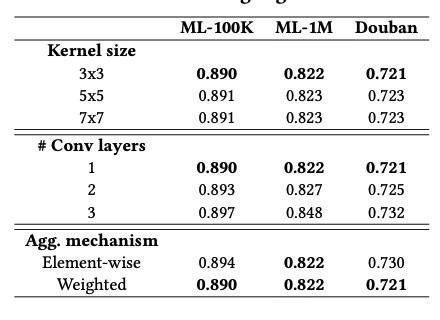

# Hyperparameter Settings

In [ ]:
# Common hyperparameter settings
n_hid = 500 # hidden layers
n_dim = 5 # RBF kernel
n_layers = 2 # number of convolution layers
gk_size = 3 # 3x3 global convolution kernel
batch_size = 32

In [ ]:
# Different hyperparameter settings for each dataset
if dataset == 'ML-100K':
    lambda_2 = 20.  # l2 regularisation
    lambda_s = 0.006
    iter_p = 5  # optimisation
    iter_f = 5
    epoch_p = 30  # training epoch
    epoch_f = 60
    dot_scale = 1  # scaled dot product

elif dataset == 'ML-1M':
    lambda_2 = 70.
    lambda_s = 0.018
    iter_p = 50
    iter_f = 10
    epoch_p = 20
    epoch_f = 30
    dot_scale = 0.5

elif dataset == 'Douban':
    lambda_2 = 10.
    lambda_s = 0.022
    iter_p = 5
    iter_f = 5
    epoch_p = 20
    epoch_f = 60
    dot_scale = 2

# Network Function

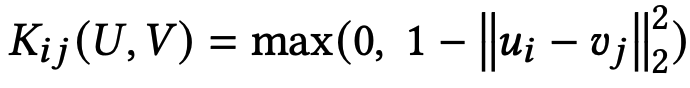

In [ ]:
def local_kernel(u, v):

    dist = tf.norm(u - v, ord=2, axis=2)
    hat = tf.maximum(0., 1. - dist**2)
    return hat

In [ ]:
class LocalKernelLayer(tf.keras.layers.Layer):
    def __init__(self, n_hid=n_hid, n_dim=n_dim, lambda_s=lambda_s, lambda_2=lambda_2, activation=tf.nn.sigmoid, **kwargs):
        super(LocalKernelLayer, self).__init__(**kwargs)
        self.n_hid = n_hid
        self.n_dim = n_dim
        self.lambda_s = lambda_s
        self.lambda_2 = lambda_2
        self.activation = activation

    def build(self, input_shape):
        dimension_idx = 1
        self.W = self.add_weight('W', [input_shape[dimension_idx], self.n_hid])
        n_in = input_shape.as_list()[dimension_idx]
        self.u = self.add_weight('u', shape=[n_in, 1, n_dim], initializer=tf.keras.initializers.TruncatedNormal(mean=0., stddev=1e-3))
        self.v = self.add_weight('u', shape=[1, self.n_hid, n_dim], initializer=tf.keras.initializers.TruncatedNormal(mean=0., stddev=1e-3))
        self.b = self.add_weight('b', [self.n_hid])

    def call(self, x):
        w_hat = local_kernel(self.u, self.v)
        sparse_reg = tf.keras.regularizers.l2(self.lambda_s)
        sparse_reg_term = sparse_reg(w_hat)
        l2_reg = tf.keras.regularizers.l2(self.lambda_2)
        l2_reg_term = l2_reg(self.W)
        W_eff = self.W * w_hat  # Local kernelised weight matrix

        y = tf.matmul(x, W_eff) + self.b
        y = self.activation(y)
        self.add_loss(sparse_reg_term + l2_reg_term)
        return y





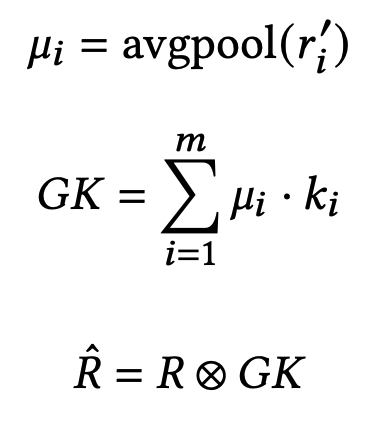

In [ ]:
def global_kernel(input, gk_size, dot_scale):
    avg_pooling = tf.reduce_mean(input, axis=1)  # Item (axis=1) based average pooling
    avg_pooling = tf.reshape(avg_pooling, [1, -1])
    n_kernel = avg_pooling.shape[1]
    conv_kernel = tf.Variable(tf.random.truncated_normal([n_kernel, gk_size**2], stddev=0.1), name='conv_kernel')
    gk = tf.matmul(avg_pooling, conv_kernel) * dot_scale  # Scaled dot product
    gk = tf.reshape(gk, [gk_size, gk_size, 1, 1])

    return gk

In [ ]:
def global_conv(input, W):
    input = tf.reshape(input, [1, input.shape[0], input.shape[1], 1])
    conv2d = tf.nn.relu(tf.nn.conv2d(input, W, strides=[1,1,1,1], padding='SAME'))
    return tf.reshape(conv2d, [conv2d.shape[1], conv2d.shape[2]])

# Network Instantiation

## Pre-training

In [ ]:
class PreTrainModel(tf.keras.Model):
    def __init__(self, n_layers=n_layers, n_hid=n_hid, n_dim=n_dim, lambda_s=lambda_s, lambda_2=lambda_2):
        super(PreTrainModel, self).__init__()
        self.layers_list = [LocalKernelLayer(name=str(i)) for i in range(n_layers)]
        self.layers_list.append(LocalKernelLayer(n_u, activation=tf.identity, name='out'))

    def call(self, x, batch_idx):
        train_r = tf.identity(x, name=None)
        train_m = np.greater(train_r, 1e-12).astype('float32')  # masks indicating non-zero entries

        reg_losses = []
        for i, layer in enumerate(self.layers_list[:-1]):
            x = layer(x)
            reg_losses.extend(layer.losses)
        pred_p = self.layers_list[-1](x)
        reg_losses.extend(self.layers_list[-1].losses)

        # L2 loss
        diff = train_m * (train_r - pred_p)
        sqE = tf.nn.l2_loss(diff)
        loss_p = sqE +  sum(reg_losses)
        begin_idx = batch_size * batch_idx
        end_idx = batch_size * (batch_idx + 1)
        error_train = tf.math.reduce_sum(train_m* (np.clip(pred_p, 1., 5.) - train_r) ** 2)  # train error
        error_test = tf.math.reduce_sum(test_m[begin_idx: end_idx, :] * (np.clip(pred_p, 1., 5.) - test_r[begin_idx: end_idx, :]) ** 2)  # test error
        return pred_p, loss_p, error_train, error_test


## Fine-tuning

In [ ]:
class FineTuneModel(tf.keras.Model):
    def __init__(self, n_layers=n_layers, n_hid=n_hid, n_dim=n_dim, lambda_s=lambda_s, lambda_2=lambda_2):
        super(FineTuneModel, self).__init__()
        self.n_layers = n_layers
        self.layers_list = [LocalKernelLayer(name=str(i)) for i in range(n_layers)]
        self.layers_list.append(LocalKernelLayer(n_u, activation=tf.identity, name='out'))
        self.layers_list = [LocalKernelLayer(name=str(i + range(n_layers + 1))) for i in range(n_layers)]
        self.layers_list.append(LocalKernelLayer(n_u, activation=tf.identity, name='out'))

    def call(self, x, batch_idx):
        train_r = tf.identity(x, name=None)
        train_m = np.greater(train_r, 1e-12).astype('float32')  # masks indicating non-zero entries

        reg_losses = []
        for i, layer in enumerate(self.layers_list[:self.n_layers]):
            x = layer(x)
        y_dash = self.layers_list[self.n_layers](x)

        gk = global_kernel(y_dash, gk_size, dot_scale)  # Global kernel
        # TODO
        y_hat = global_conv(train_r, gk)  # Global kernel-based rating matrix
        for i, layer in enumerate(self.layers_list[self.n_layers + 1:]):
            y_hat = layer(x)
            reg_losses.extend(layer.losses)

        pred_f = self.layers_list[-1](x)
        reg_losses.extend(self.layers_list[-1].losses)


        # L2 loss
        diff = train_m * (train_r - pred_f)
        sqE = tf.nn.l2_loss(diff)
        loss_p = sqE +  sum(reg_losses)
        begin_idx = batch_size * batch_idx
        end_idx = batch_size * (batch_idx + 1)
        error_train = tf.math.reduce_sum(train_m* (np.clip(pred_f, 1., 5.) - train_r) ** 2)  # train error
        error_test = tf.math.reduce_sum(test_m[begin_idx: end_idx, :] * (np.clip(pred_f, 1., 5.) - test_r[begin_idx: end_idx, :]) ** 2)  # test error

        test_mae = tf.math.reduce_sum(test_m[begin_idx: end_idx, :] * np.abs(np.clip(pred_f, 1., 5.) - test_r[begin_idx: end_idx, :]))
        train_mae = tf.math.reduce_sum(train_m * np.abs(np.clip(pred_f, 1., 5.) - train_r))

        test_ndcg = call_ndcg(np.clip(pred_f, 1., 5.), test_r[begin_idx: end_idx, :])
        train_ndcg = call_ndcg(np.clip(pred_f, 1., 5.), train_r)

        return pred_f, loss_p, error_train, error_test, test_mae, train_mae, test_ndcg, train_ndcg


# Evaluation code

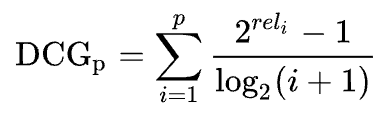

In [ ]:
# Discounted cumulative gain
def dcg_k(score_label, k):
    dcg, i = 0., 0
    for s in score_label:
        if i < k:
            dcg += (2**s[1]-1) / np.log2(2+i)
            i += 1
    return dcg

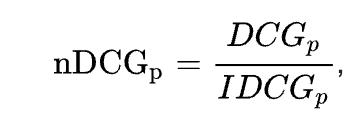


where IDCG is ideal discounted cumulative gain

In [ ]:
# Normalized DCG
def ndcg_k(y_hat, y, k):
    score_label = np.stack([y_hat, y], axis=1).tolist()
    score_label = sorted(score_label, key=lambda d:d[0], reverse=True)
    score_label_ = sorted(score_label, key=lambda d:d[1], reverse=True)
    norm, i = 0., 0
    for s in score_label_:
        if i < k:
            norm += (2**s[1]-1) / np.log2(2+i)
            i += 1
    dcg = dcg_k(score_label, k)
    return dcg / norm

In [ ]:
def call_ndcg(y_hat, y):
    ndcg_sum, num = 0, 0
    y_hat, y = tf.transpose(y_hat), tf.transpose(y)
    n_users = y.shape[0]

    for i in range(n_users):
        mask = y[i] != 0
        y_hat_i = tf.boolean_mask(y_hat[i], mask)
        y_i = tf.boolean_mask(y[i], mask)

        if y_i.shape[0] < 2:
            continue

        ndcg_sum += ndcg_k(y_hat_i, y_i, y_i.shape[0])  # user-wise calculation
        num += 1

    return ndcg_sum / num

# Training and Test Loop

In [ ]:
# Convert the numpy array to a tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(train_r)

# Shuffle and batch the dataset
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)



In [ ]:
def pre_train(dataset, model, optimizer):

    for step, data in enumerate(dataset):
        loss = None
        error_test_total = None
        error_train_total = None
        # Run the forward pass of the layer.
        # The operations that the layer applies to its inputs are going to be recorded on the GradientTape.
        with tf.GradientTape() as tape:
            pred_p, loss_p, error_test, error_train = model(data, step)
            if error_test_total is None:
                error_test_total = error_test
                error_train_total = error_train
            else:
                error_test_total += error_test
                error_train_total += error_train

        grads = tape.gradient(loss_p, model.trainable_weights)
        # Run one step of gradient descent by updating the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_rmse = np.sqrt(error_train_total/tf.math.reduce_sum(train_m))
    test_rmse = np.sqrt(error_test_total/tf.math.reduce_sum(test_m))
    return train_rmse, test_rmse


In [ ]:
def fine_tune(dataset, model, optimizer):

    for step, data in enumerate(dataset):
        if step > 4:
          break
        loss = None
        error_test_total = None
        error_train_total = None
        test_mae_total = None
        train_mae_total = None
        test_ndcg_total = None
        train_ndcg_total = None


        # Run the forward pass of the layer.
        # The operations that the layer applies to its inputs are going to be recorded on the GradientTape.
        with tf.GradientTape() as tape:
            pred_f, loss_p, error_train, error_test, test_mae, train_mae, test_ndcg, train_ndcg = model(data, step)
            if error_test_total is None:
                error_test_total = error_test
                error_train_total = error_train
                test_mae_total = test_mae
                train_mae_total = train_mae
                test_ndcg_total = test_ndcg
                train_ndcg_total = train_ndcg
            else:
                error_test_total += error_test
                error_train_total += error_train
                test_mae_total += test_mae
                train_mae_total += train_mae
                test_ndcg_total += test_ndcg
                train_ndcg_total += train_ndcg
        grads = tape.gradient(loss_p, model.trainable_weights)
        # Run one step of gradient descent by updating the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_rmse = np.sqrt(error_train_total/tf.math.reduce_sum(train_m))
    test_rmse = np.sqrt(error_test_total/tf.math.reduce_sum(test_m))

    train_mae = train_mae_total / tf.math.reduce_sum(test_m)
    test_mae = test_mae_total / tf.math.reduce_sum(test_m)

    train_ndcg = train_ndcg_total
    test_ndcg = test_ndcg_total
    return train_rmse, test_rmse, train_mae, test_mae, train_ndcg, test_ndcg

In [ ]:
# Create an instance of the model
model = PreTrainModel()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

time_cumulative = 0
#for i in range(epoch_p):
for i in range(2):
    tic = time()
    train_rmse, test_rmse = pre_train(train_dataset, model, optimizer)
    t = time() - tic
    time_cumulative += t
    print('.-^-._' * 3)
    print('PRE-TRAINING')
    print('Epoch:', i+1)
    print('test rmse:', test_rmse)
    print('train rmse:', train_rmse)
    print('Time:', t, 'seconds')
    print('Time cumulative:', time_cumulative, 'seconds')
    print('.-^-._' * 3)

In [ ]:

best_rmse_ep, best_mae_ep, best_ndcg_ep = 0, 0, 0
best_rmse, best_mae, best_ndcg = float("inf"), float("inf"), 0
model = FineTuneModel()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

for i in range(2):
    tic = time()
    train_rmse, test_rmse, train_mae, test_mae, train_ndcg, test_ndcg = fine_tune(train_dataset, model, optimizer)
    if test_rmse < best_rmse:
        best_rmse = test_rmse
        best_rmse_ep = i+1

    if test_mae < best_mae:
        best_mae = test_mae
        best_mae_ep = i+1

    if best_ndcg < test_ndcg:
        best_ndcg = test_ndcg
        best_ndcg_ep = i+1
    t = time() - tic
    time_cumulative += t
    print('.-^-._' * 3)
    print('PRE-TRAINING')
    print('Epoch:', i+1)
    print('test rmse:', test_rmse)
    print('train rmse:', train_rmse)
    print('Time:', t, 'seconds')
    print('Time cumulative:', time_cumulative, 'seconds')
    print('.-^-._' * 3)

In [ ]:

# Final result
print('Epoch:', best_rmse_ep, ' best rmse:', best_rmse)
print('Epoch:', best_mae_ep, ' best mae:', best_mae)
print('Epoch:', best_ndcg_ep, ' best ndcg:', best_ndcg)